<a href="https://colab.research.google.com/github/atlantiquesun/Miscellaneous/blob/master/cmv_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Section 1
import glob
import json
import logging
import bz2

# Section 2
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
import re
import numpy as np
import pandas as pd

# Section 3
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator

# 1. Load Data

In [2]:
# provided code
def load_big_jsonlist(fpath):
  filenames = glob.glob(fpath)
  data = []
  for filename in filenames:
    logging.info(filename)
    with bz2.BZ2File(filename, "r") as f:
      count = 0
      for line in f:
        entry = json.loads(line)
        data.append(entry)        
        count += 1
        if count % 1000 == 0:
          logging.info(count)
    logging.info("Loading complete.")
  print('loading complete')
  return data

In [3]:
fpath = "/content/drive/MyDrive/Research/cmv/train_period_data.jsonlist.bz2"
data = load_big_jsonlist(fpath)

loading complete


# 2. Data Processing

**2.1 Functions for finding deltas in a string**

In [4]:
'''
reference: 
1. https://github.com/alexames/DeltaBot/blob/master/deltabot/deltabot.py
2. https://github.com/alexames/DeltaBot/blob/master/config/config.json.example
'''


def skippable_line(line):
    """ Returns true if the given line is a quote or code """
    return re.search('(^    |^ *&gt;)', line) is not None


def str_contains_delta(text, tokens=[chr(8710), chr(916), "&amp;#8710;", "!delta"]):
    """ 
    Returns true if a given string contains one of the given tokens, as long
    as the token is not inside a quote or code block 
    """
    lines = text.split('\n')
    in_quote = False
    for line in lines:
        if not line:  # Empty string
            in_quote = False
        if in_quote:
            continue
        if not skippable_line(line):
            for token in tokens:
                if token in line:
                    return True
        else:
            in_quote = True
    return False


**2.2 Functions for determining if the OP awarded a valid delta in a discussion tree**



In [5]:
def bot_confirms_delta(disc_tree, id):
  '''
  Returns True if DeltaBot confirmed the delta assignment comment whose id is 'id'; returns False otherwise
  '''

  for comment in disc_tree["comments"]: 
    if(("body" in comment.keys()) and (comment["author"] == "DeltaBot") and (comment["parent_id"].split('_')[1] == id)):
      if("Confirmed" in comment["body"]):  
        return True

  return False


def tree_contains_delta(disc_tree):
  '''
  Returns True if 'disc_tree' contains a valid delta awarded by the OP; returns False otherwise
  '''

  op = disc_tree["author"]

  for comment in disc_tree["comments"]:
    if("body" in comment.keys()):
      if(comment["author"] == op and str_contains_delta(comment["body"])): # check if the OP awarded a delta
        if(bot_confirms_delta(disc_tree, comment["id"])): # check if the delta is valid
          return True
  
  return False

**2.3 Functions for calculating average delta percentages**

In [6]:
def std_error(row):
  '''
  Returns the standard error(%) of the average delta percentage in a month 
  (each month is represented as a row in pandas.DataFrame)
  '''

  std_dev = np.sqrt((row["delta_count"]*np.square(1-0.01*row["delta_percentage"]) 
            + (row["tree_count"]-row["delta_count"])*np.square(0.01*row["delta_percentage"]))/row["tree_count"])
  std_error = 100*(std_dev/np.sqrt(row["tree_count"]))
  return std_error


def get_delta_info(data, start_month="2013-02-01", end_month="2015-04-01"):
  '''
  Returns a pandas.DataFrame documenting 
  1. monthly discussion tree count ("tree_count")
  2. monthly number of trees that contain a valid delta awarded by OPs ("delta_count")
  3. monthly average delta percentage ("delta_percentage") 
  4. the standard error of monthly average delta percentage ("std_error")
  '''

  # initialize the pandas.DataFrame
  start_month = pd.to_datetime(start_month, utc=True)
  end_month = pd.to_datetime(end_month, utc=True)
  months = pd.date_range(start=start_month, end=end_month, freq="MS")
  df = pd.DataFrame(0, index=months, columns=["tree_count", "delta_count", "delta_percentage", "std_error"])

  # generate monthly discussion tree count and monthly number of trees that contain a valid delta from OPs
  for disc_tree in data:

    created_date = datetime.utcfromtimestamp(disc_tree["created_utc"])
    created_month = created_date.replace(day=1, hour=0, minute=0, second=0, microsecond=0, tzinfo=timezone.utc) # get the start of the corresponding month
    
    if(created_month >= start_month and created_month <= end_month):
      df.at[created_month, "tree_count"] += 1
    else:
      continue

    if(tree_contains_delta(disc_tree)):
      df.at[created_month, "delta_count"] += 1
  
  # calculate delta percentage and standard error
  df["delta_percentage"] = 100*(df["delta_count"]/df["tree_count"])
  df["std_error"] = df.apply(std_error, axis=1)
  
  df.index = [t.strftime("%Y%m") for t in list(df.index)]
  return df


In [10]:
df = get_delta_info(data)
display(df)

,tree_count,delta_count,delta_percentage,std_error
201302,111,26,23.423423,4.019867
201303,263,71,26.996198,2.737450
201304,585,150,25.641026,1.805329
201305,1115,229,20.538117,1.209824
201306,1029,224,21.768707,1.286468
201307,716,147,20.530726,1.509542
201308,959,182,18.978102,1.266247
201309,748,154,20.588235,1.478431
201310,669,148,22.122571,1.604762
201311,730,142,19.452055,1.465037


# 3. Plotting

In [11]:
def plot_delta_percentage(df, fig_path):
  '''
  Plot 'df' and save the plot to 'fig_path'
  '''

  # create a plot
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.errorbar(x=list(df.index), y=df["delta_percentage"], yerr=df["std_error"], linestyle='-', marker='o', color='r')
  
  # set xticks
  major_xticks = list(range(0, len(list(df.index)), 4)) + [len(list(df.index))-1]
  ax.xaxis.set_major_locator(FixedLocator(major_xticks))
  ax.xaxis.set_minor_locator(MultipleLocator(1))
  ax.tick_params(axis='x', rotation=45, labelsize=14, which="both", direction="in", bottom=True, top=True, labelbottom=True, labeltop=False) 

  # set yticks
  ax.set_yticks([20, 30, 40])
  ax.set_yticklabels(["20%", "30%", "40%"])
  ax.tick_params(axis='y', labelsize=14) 
  plt.ylabel("delta percentage", fontsize=14)

  ax.margins(x=0.1)
  plt.savefig(fig_path, bbox_inches="tight") 
  plt.show()

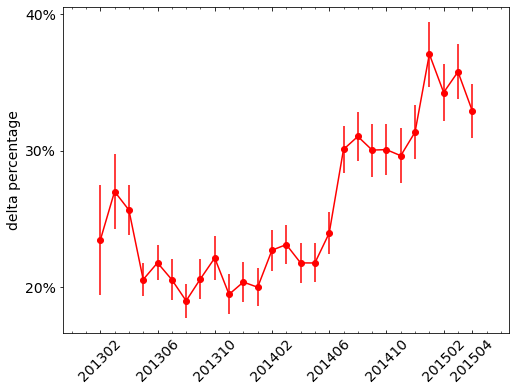

In [12]:
fig_path = "/content/drive/MyDrive/Research/cmv/delta_percentage_v2.png"
plot_delta_percentage(df, fig_path)